In [1]:
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog('rdApp.error')

## Assess data splitting

In [5]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
valid = pd.read_csv("valid.csv")

total = pd.concat([train, test, valid]).shape[0]

In [6]:
print(train.shape[0] / total)
print(valid.shape[0] / total)
print(test.shape[0] / total)

0.6826056826056826
0.20997920997921
0.10741510741510742


In [46]:
import numpy as np

y_test_sum = np.sum(test.iloc[:, 2:])
y_train_sum = np.sum(train.iloc[:, 2:])
y_validation_sum = np.sum(valid.iloc[:, 2:])

sum_of_all = pd.DataFrame([y_train_sum, y_validation_sum, y_test_sum], index=["train", "validation", "test"])

In [47]:
sum_of_all.loc['Validation relative split', :] = sum_of_all.loc['validation', :] / (sum_of_all.loc['train', :] + sum_of_all.loc['test', :] + sum_of_all.loc['validation', :]) * 100

sum_of_all.loc['Test relative split', :] = sum_of_all.loc['test', :] / (sum_of_all.loc['train', :] + sum_of_all.loc['test', :] + sum_of_all.loc['validation', :]) * 100
sum_of_all.loc['Train relative split', :] = sum_of_all.loc['train', :] / (sum_of_all.loc['train', :] + sum_of_all.loc['test', :]+ sum_of_all.loc['validation', :]) * 100

In [48]:
df = pd.melt(sum_of_all.T.reset_index(), id_vars=['index']).rename(columns={'index': 'Precursor', 'value': 'Percentage of data'})
df = df[(df["variable"]!="train") & (df["variable"]!="validation") & (df["variable"]!="test")]

In [49]:
df1 = sum_of_all.loc['Test relative split', :].describe()
df2 = sum_of_all.loc['Train relative split', :].describe()
df3 = sum_of_all.loc['Validation relative split', :].describe()
df_all = pd.concat([df1, df2, df3], axis=1)
df_all.drop(['count'], inplace=True)
table_styled = df_all.style.background_gradient(cmap="YlGn")
table_styled
table_styled.to_html("split_result.html")

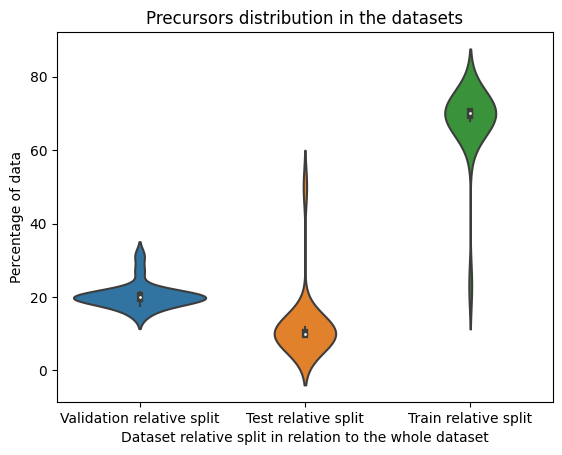

In [51]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.violinplot(data=df, x = "variable", y = "Percentage of data")
#add title and axis names
plt.title('Precursors distribution in the datasets')
# write x and y labels titles
plt.xlabel('Dataset relative split in relation to the whole dataset')
plt.ylabel('Percentage of data')
plt.savefig("split_result.png")

In [52]:
train.shape

(985, 22)

In [54]:
valid.shape

(303, 22)

In [55]:
test.shape

(155, 22)

# Assess pipelines

In [8]:
from deepmol.loaders import CSVLoader

train = CSVLoader("train.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341',
                                       'C00353', 'C00448', 'C01789', 'C03506',
                                       'C00047', 'C00108', 'C00187', 'C00148', 'C00041',
                                       'C00129', 'C00062', 'C01852', 'C00049', 'C00135'],
                        id_field="ids", smiles_field="smiles").create_dataset()
valid = CSVLoader("valid.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341',
                                       'C00353', 'C00448', 'C01789', 'C03506',
                                       'C00047', 'C00108', 'C00187', 'C00148', 'C00041',
                                       'C00129', 'C00062', 'C01852', 'C00049', 'C00135'],
                        id_field="ids", smiles_field="smiles").create_dataset()
test = CSVLoader("test.csv",
                  labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341',
                                 'C00353', 'C00448', 'C01789', 'C03506',
                                 'C00047', 'C00108', 'C00187', 'C00148', 'C00041',
                                 'C00129', 'C00062', 'C01852', 'C00049', 'C00135'],
                  id_field="ids", smiles_field="smiles").create_dataset()

2023-09-20 15:35:09,183 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2023-09-20 15:35:09,254 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2023-09-20 15:35:09,288 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


In [7]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, balanced_accuracy_score
from deepmol.metrics import Metric


def f1_score_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

def precision_macro(y_true, y_pred):
    return precision_score(y_true, y_pred, average='macro')

def recall_macro(y_true, y_pred):
    return recall_score(y_true, y_pred, average='macro')


f1_score_macro_metric = Metric(f1_score_macro)
precision_score_macro_metric = Metric(precision_macro)
recall_score_macro_metric = Metric(recall_macro)
accuracy_score_metric = Metric(balanced_accuracy_score)

## Now we are going to evaluate the best pipelines from each of the optimizers

In [2]:
import numpy as np
labels = np.array(['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341',
                                       'C00353', 'C00448', 'C01789', 'C03506',
                                       'C00047', 'C00108', 'C00187', 'C00148', 'C00041',
                                       'C00129', 'C00062', 'C01852', 'C00049', 'C00135'])

labels_ = {
    'C00341': 'Geranyl diphosphate',
    'C01789': 'Campesterol',
    'C00078': 'Tryptophan',
    'C00049': 'L-Aspartate',
    'C00183': 'L-Valine',
    'C03506': 'Indoleglycerol phosphate',
    'C00187': 'Cholesterol',
    'C00079': 'L-Phenylalanine',
    'C00047': 'L-Lysine',
    'C01852': 'Secologanin',
    'C00407': 'L-Isoleucine',
    'C00129': 'Isopentenyl diphosphate',
    'C00235': 'Dimethylallyl diphosphate',
    'C00062': 'L-Arginine',
    'C00353': 'Geranylgeranyl diphosphate',
    'C00148': 'L-Proline',
    'C00073': 'L-Methionine',
    'C00108': 'Anthranilate',
    'C00123': 'L-Leucine',
    'C00135': 'L-Histidine',
    'C00448': 'Farnesyl diphosphate',
    'C00082': 'L-Tyrosine',
    'C00041': 'L-Alanine'
}

labels_names = np.array([labels_[label] for label in labels])
labels_names

array(['L-Methionine', 'Tryptophan', 'L-Phenylalanine', 'L-Tyrosine',
       'Dimethylallyl diphosphate', 'Geranyl diphosphate',
       'Geranylgeranyl diphosphate', 'Farnesyl diphosphate',
       'Campesterol', 'Indoleglycerol phosphate', 'L-Lysine',
       'Anthranilate', 'Cholesterol', 'L-Proline', 'L-Alanine',
       'Isopentenyl diphosphate', 'L-Arginine', 'Secologanin',
       'L-Aspartate', 'L-Histidine'], dtype='<U26')

In [11]:
import os
from deepmol.pipeline import Pipeline
import pandas as pd
results_dataframe = pd.DataFrame(columns=["Pipeline", "Trial", "Overall Score"] + list(labels_names))

best_pipelines = os.listdir("pipelines")
for pipeline in best_pipelines:
    list_pipelines = os.listdir("pipelines/" + pipeline)
    for trial in list_pipelines:
        trial_pipeline = Pipeline.load(os.path.join("pipelines/", pipeline, trial))
        score, per_metric_score = trial_pipeline.evaluate(test, metrics=[f1_score_macro_metric], per_task_metrics=True)
        new_dataframe = pd.DataFrame([[pipeline, trial, score["f1_score_macro"]] + list(per_metric_score["f1_score_macro"])], columns=["Pipeline", "Trial", "Overall Score"] + list(labels_names))
        results_dataframe = pd.concat([results_dataframe, new_dataframe])

[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Normalizer
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharger
[15:36:18] Running Uncharge

In [12]:
results_dataframe.Pipeline = results_dataframe.Pipeline.str.replace("sm_predictor_pipeline_", "")
results_dataframe

,Pipeline,Trial,Overall Score,L-Methionine,Tryptophan,L-Phenylalanine,L-Tyrosine,Dimethylallyl diphosphate,Geranyl diphosphate,Geranylgeranyl diphosphate,...,L-Lysine,Anthranilate,Cholesterol,L-Proline,L-Alanine,Isopentenyl diphosphate,L-Arginine,Secologanin,L-Aspartate,L-Histidine
0,quasi_mote_carlo,trial_383,0.721098,1.0,0.985334,0.865251,0.901623,1.000000,0.913311,0.956412,...,0.858620,0.925193,0.831705,0.615066,0.831705,0.872302,0.713917,0.871689,0.746732,0.831705
0,quasi_mote_carlo,trial_466,0.790533,1.0,0.971296,0.886971,0.940015,0.926921,1.000000,0.956412,...,1.000000,1.000000,0.831705,0.793333,0.831705,0.872302,0.793333,0.942783,0.898361,0.831705
0,quasi_mote_carlo,trial_121,0.796899,1.0,0.971296,0.881254,0.942593,1.000000,1.000000,0.943103,...,1.000000,1.000000,1.000000,0.690000,0.831705,0.872302,0.713917,0.942783,0.898361,0.831705
0,random,trial_216,0.730327,1.0,0.985334,0.860184,0.926672,1.000000,0.925193,0.894390,...,1.000000,1.000000,0.780764,0.850386,0.831705,0.872302,0.858620,0.942783,0.898361,0.831705
0,random,trial_71,0.768892,1.0,0.942593,0.916110,0.956003,1.000000,0.952873,0.924762,...,0.879565,0.925193,1.000000,0.739933,0.831705,0.954837,0.690000,0.871689,0.830044,0.831705
0,random,trial_276,0.785195,1.0,0.970008,0.868133,0.892585,1.000000,0.858620,0.939401,...,0.879565,0.925193,1.000000,0.739933,0.831705,0.954837,0.793333,0.871689,0.898361,1.000000
0,evolutionary,trial_482,0.783414,1.0,0.957838,0.905809,0.913889,1.000000,1.000000,0.953787,...,0.952873,1.000000,1.000000,0.713917,0.831705,0.872302,0.713917,0.942783,0.898361,0.831705
0,evolutionary,trial_366,0.777760,1.0,0.985334,0.868133,0.929731,1.000000,1.000000,0.966845,...,0.896667,1.000000,0.831705,0.713917,0.831705,0.872302,0.713917,0.942783,0.898361,0.831705
0,evolutionary,trial_449,0.814889,1.0,0.985334,0.889286,0.923275,1.000000,0.952873,0.977575,...,0.913311,0.925193,1.000000,0.793333,0.831705,0.872302,0.793333,0.871689,0.898361,1.000000
0,tpe,trial_289,0.818871,1.0,0.985334,0.876236,0.913889,1.000000,1.000000,0.977575,...,1.000000,1.000000,1.000000,0.793333,0.831705,0.872302,0.793333,0.942783,0.898361,0.831705


In [17]:
results_dataframe.Pipeline = results_dataframe.Pipeline.str.replace("quasi_mote_carlo", "Quasi Monte Carlo")
results_dataframe.Pipeline = results_dataframe.Pipeline.str.replace("random", "Random")
results_dataframe.Pipeline = results_dataframe.Pipeline.str.replace("tpe", "TPE")
results_dataframe.Pipeline = results_dataframe.Pipeline.str.replace("evolutionary", "Evolutionary algorithm")

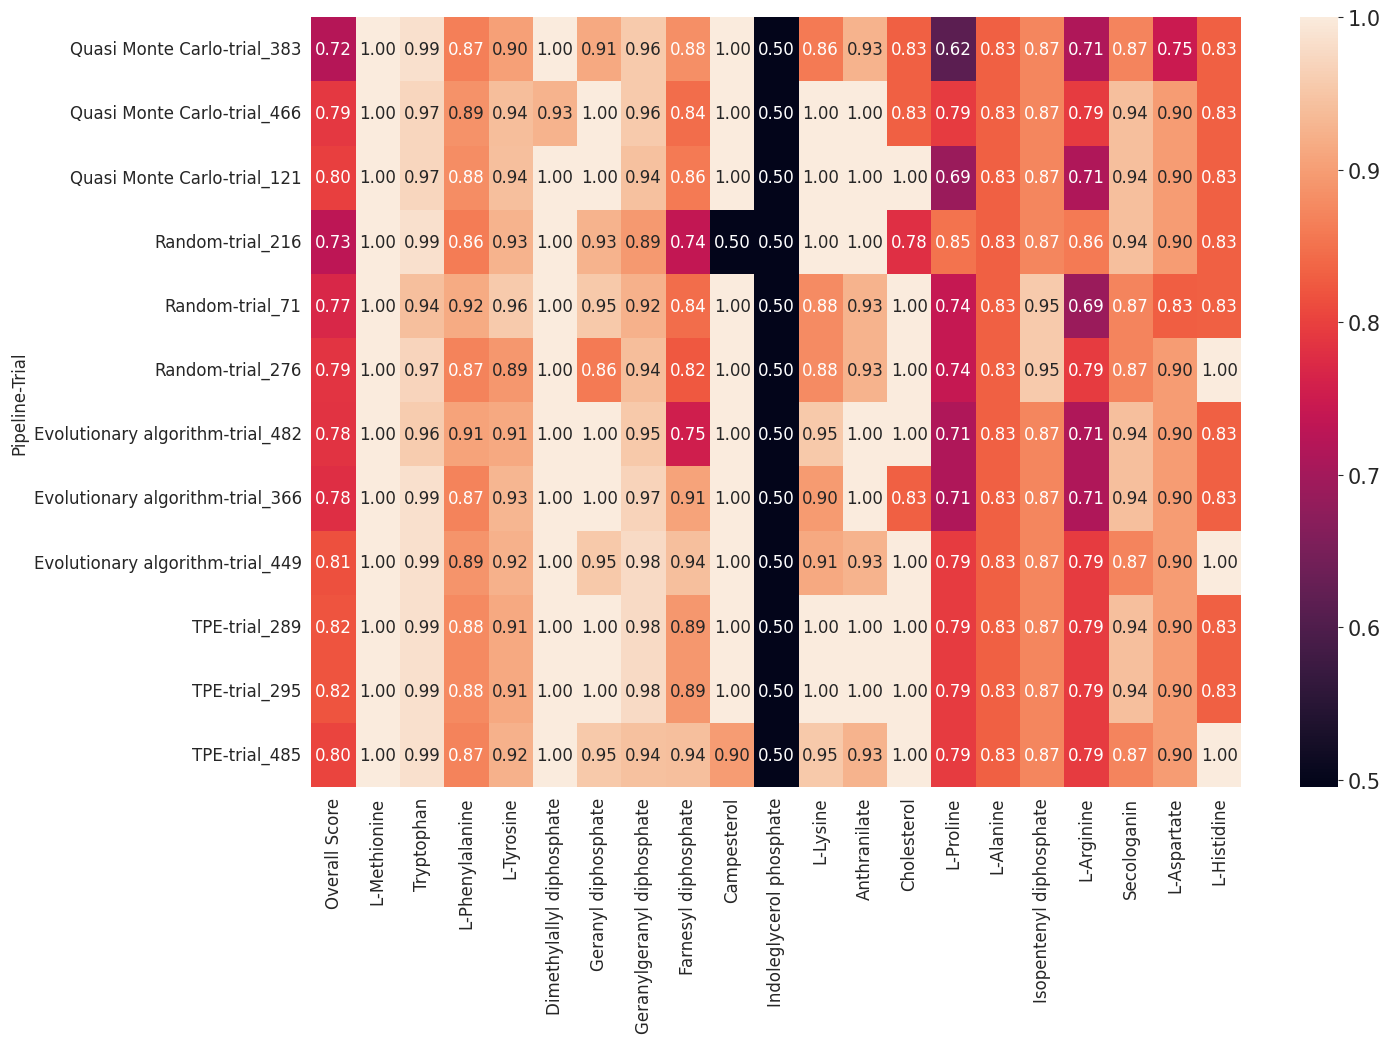

In [25]:
from copy import copy
import seaborn as sns
import matplotlib.pyplot as plt

results = copy(results_dataframe)

plt.rcParams.update({'font.size': 12})
results.set_index(["Pipeline", "Trial"], inplace=True)
plt.figure(figsize=(15, 10))  # Set the figure size
sns.heatmap(results.iloc[:, :], annot=True, fmt=".2f", cbar=True)
# increase the fontsize of the colorbar ticklabels
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=15)

In [3]:
from deepmol.loaders import CSVLoader

indepedent = CSVLoader("../compounds_to_test/PhytoHub_Compounds.csv",
                        id_field="Chemical Name", smiles_field="Smiles").create_dataset(sep="\t")

In [2]:
from rdkit import Chem
from rdkit.Chem import MolToSmiles

reader1 = Chem.SmilesMolSupplier("../compounds_to_test/LOTUS_DB.smi", delimiter="\t")
mols = [mol for mol in reader1]
ids = [mol.GetProp("_Name") for mol in mols]
smiles=[MolToSmiles(mol) for mol in mols]

In [2]:
from deepmol.datasets import SmilesDataset


lotus_dataset = SmilesDataset(smiles=smiles, mols=mols, ids=ids)

In [7]:
lotus_dataset.to_csv("lotus_dataset.csv")

In [ ]:
np.savetxt("predictions.txt", predictions)